# Analisi Statistica e Probabilistica delle Performance di Tiro NBA
**Esame di Fondamenti di Probabilità e Statistica**
*Studente: [Tuo Nome]*

## 1. Obiettivo e Contesto
Questo progetto applica metodi statistici avanzati per analizzare le dinamiche di tiro nel basket NBA. L'obiettivo è comprendere come la **distanza** influenzi la probabilità di successo e modellare matematicamente il comportamento di un tiratore.

Le analisi includono:
1.  **Statistica Descrittiva:** Misure di posizione (Media, Mediana, Moda) e dispersione (Varianza, IQR) della distanza di tiro.
2.  **Visualizzazione Dati:** Istogrammi, Box Plot e Density Plot (Heatmap) per analizzare la distribuzione spaziale.
3.  **Calcolo delle Probabilità:** Applicazione della distribuzione Binomiale per prevedere serie di tiri.
4.  **Inferenza e Modellazione:** Analisi della Covarianza e implementazione di una **Regressione Logistica** per stimare la probabilità di canestro in funzione della distanza.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode, binom
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math
import warnings
import os

# Configurazione Grafica
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

# 1. Caricamento Dati
# Assicurati che il file sia nella cartella 'data' o modifica il percorso
try:
    df = pd.read_csv(os.path.join("data", "shots_all_seasons.csv"), low_memory=False)
except FileNotFoundError:
    print("Errore: File non trovato. Controlla il percorso 'data/shots_all_seasons.csv'")

# 2. Feature Engineering (Pulizia e Trasformazione)
# Calcoliamo la distanza euclidea dal canestro (0,0) usando le coordinate X e Y
# I dati originali sono in decimi di piedi, dividiamo per 10 per avere i piedi (feet)
df['DISTANCE'] = np.sqrt(df['LOC_X']**2 + df['LOC_Y']**2) / 10

# Rimuoviamo tiri da distanze estreme (es. oltre metà campo > 45 piedi) per pulizia statistica
df = df[df['DISTANCE'] <= 40]

# Convertiamo SHOT_MADE in numerico (1=Segnato, 0=Sbagliato) per le analisi successive
df['SHOT_MADE_NUM'] = df['SHOT_MADE'].replace({True: 1, False: 0}).astype(int)

print(f"Dataset caricato con successo: {df.shape[0]} osservazioni totali.")
df.head()

Dataset caricato con successo: 4450789 osservazioni totali.


,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,DISTANCE,SHOT_MADE_NUM
0,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,LC,24+ ft.,20.0,21.35,25,6,0,0,2.925444,1
1,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,C,Less Than 8 ft.,-0.0,5.25,0,6,0,2,0.525000,1
2,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,LC,16-24 ft.,13.3,24.45,23,6,0,9,2.783330,0
3,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,L,16-24 ft.,16.4,13.95,18,6,0,31,2.153050,1
4,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,R,16-24 ft.,-15.8,7.85,16,6,0,55,1.764263,0


## 2. Statistica Descrittiva Univariata
Analizziamo la variabile quantitativa continua **`DISTANCE`**. Selezioniamo un giocatore campione per l'analisi dettagliata (es. **Stephen Curry**, noto per il tiro da 3 punti).

Calcoleremo:
* **Media e Mediana:** Per capire la tendenza centrale.
* **Moda:** La distanza più frequente.
* **Varianza e Deviazione Standard:** Per quantificare la variabilità della scelta di tiro.
* **Percentili:** Per capire come si distribuiscono i tiri (es. il 75% dei tiri avviene entro X metri).

In [2]:
# SELEZIONE DEL CASO DI STUDIO
PLAYER_TARGET = "Stephen Curry"
SEASON_TARGET = "2015-16" # Stagione da MVP unanime

# Filtriamo il dataset
player_data = df[(df['PLAYER_NAME'] == PLAYER_TARGET) & (df['SEASON_2'] == SEASON_TARGET)].copy()
distances = player_data['DISTANCE'].values

# CALCOLI STATISTICI (Numpy & Scipy)
stats = {
    "Media (Mean)": np.mean(distances),
    "Mediana (Median)": np.median(distances),
    "Moda (Mode)": mode(distances, keepdims=True).mode[0],
    "Varianza": np.var(distances),
    "Deviazione Standard (Std Dev)": np.std(distances),
    "Minimo": np.min(distances),
    "Massimo": np.max(distances),
    "Percentile 25% (Q1)": np.percentile(distances, 25),
    "Percentile 75% (Q3)": np.percentile(distances, 75)
}

print(f"--- Statistiche Descrittive: {PLAYER_TARGET} ({SEASON_TARGET}) ---")
for key, val in stats.items():
    print(f"{key}: {val:.2f} piedi")

print(f"\nInterpretazione: Una deviazione standard di {stats['Deviazione Standard (Std Dev)']:.2f} indica un'alta variabilità, tipica di un giocatore che tira da ogni posizione.")

--- Statistiche Descrittive: Stephen Curry (2015-16) ---
Media (Mean): 2.20 piedi
Mediana (Median): 2.58 piedi
Moda (Mode): 0.69 piedi
Varianza: 1.22 piedi
Deviazione Standard (Std Dev): 1.11 piedi
Minimo: 0.37 piedi
Massimo: 7.65 piedi
Percentile 25% (Q1): 0.85 piedi
Percentile 75% (Q3): 3.05 piedi

Interpretazione: Una deviazione standard di 1.11 indica un'alta variabilità, tipica di un giocatore che tira da ogni posizione.


## 3. Analisi Grafica e Distribuzioni
Utilizziamo grafici avanzati per visualizzare la distribuzione dei dati:
1.  **Istogramma e KDE:** Mostra la frequenza dei tiri per distanza (Noteremo una distribuzione bimodale: tiri sotto canestro vs tiri da 3).
2.  **Box Plot:** Confrontiamo la distribuzione delle distanze dei tiri **Segnati vs Sbagliati**.
3.  **Density Plot (Heatmap):** Visualizzazione spaziale della densità di tiro sul campo.

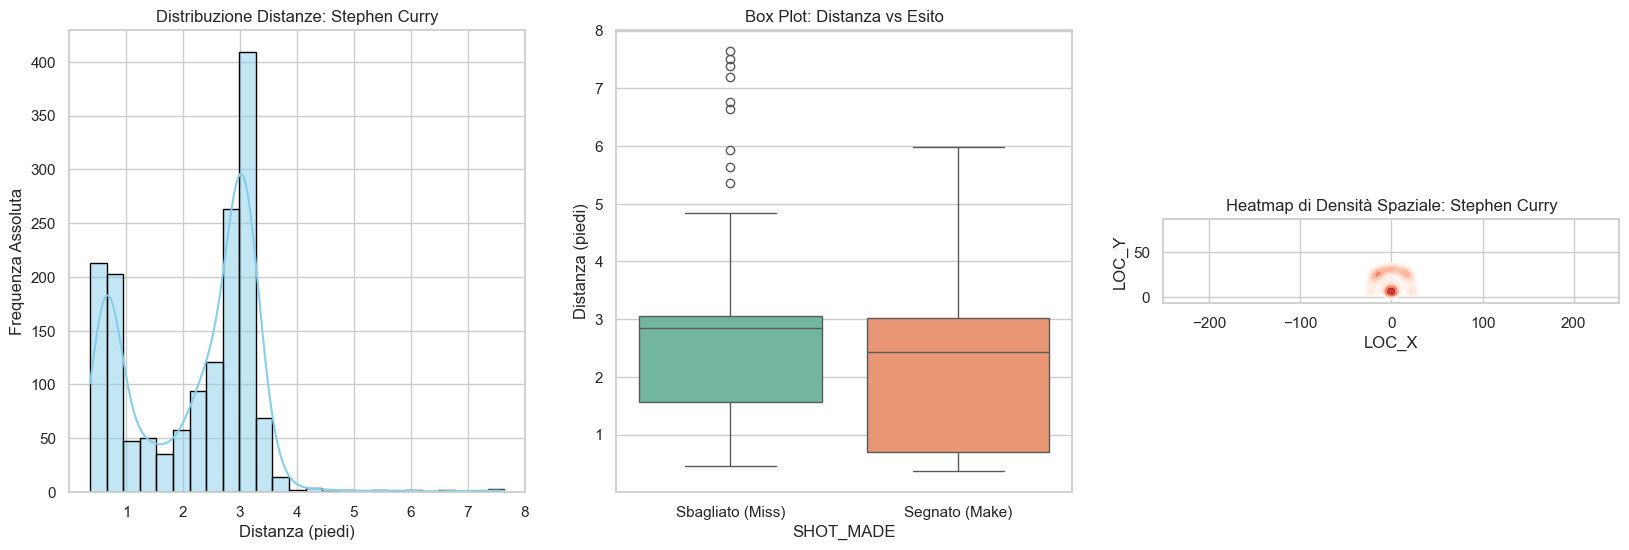

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# 1. Istogramma con Kernel Density Estimation (KDE)
sns.histplot(player_data['DISTANCE'], bins=25, kde=True, ax=ax[0], color='skyblue', edgecolor='black')
ax[0].set_title(f'Distribuzione Distanze: {PLAYER_TARGET}')
ax[0].set_xlabel('Distanza (piedi)')
ax[0].set_ylabel('Frequenza Assoluta')

# 2. Box Plot (Segnati vs Sbagliati)
sns.boxplot(x='SHOT_MADE', y='DISTANCE', data=player_data, ax=ax[1], palette="Set2")
ax[1].set_title('Box Plot: Distanza vs Esito')
ax[1].set_xticklabels(['Sbagliato (Miss)', 'Segnato (Make)'])
ax[1].set_ylabel('Distanza (piedi)')

# 3. Spatial Density Plot (Heatmap del campo)
# Filtriamo i dati per una visualizzazione migliore (solo tiri offensivi standard)
subset = player_data[player_data['LOC_Y'] < 400] 
sns.kdeplot(
    data=subset, x='LOC_X', y='LOC_Y', 
    fill=True, cmap="Reds", thresh=0.05, levels=10, ax=ax[2], alpha=0.8
)
ax[2].set_title(f'Heatmap di Densità Spaziale: {PLAYER_TARGET}')
ax[2].set_aspect('equal')
ax[2].set_xlim(-250, 250)

plt.show()

## 4. Probabilità e Calcolo Combinatorio
In questa sezione applichiamo i concetti di probabilità teorica.
Utilizziamo la **Distribuzione Binomiale** per rispondere a domande probabilistiche complesse.

**Formula Binomiale:**
$$P(X=k) = \binom{n}{k} p^k (1-p)^{n-k}$$

Dove:
* $n$: numero di prove (tiri tentati)
* $k$: numero di successi (canestri segnati)
* $p$: probabilità frequentista di successo (FG% del giocatore)

Probabilità Frequentista (3PT% Reale): 45.36%

--- Applicazione Modello Binomiale ---
Scenario: 12 tentativi con p=0.45
Probabilità di segnarne esattamente 7: 15.24% (Calcolata con combinazioni)


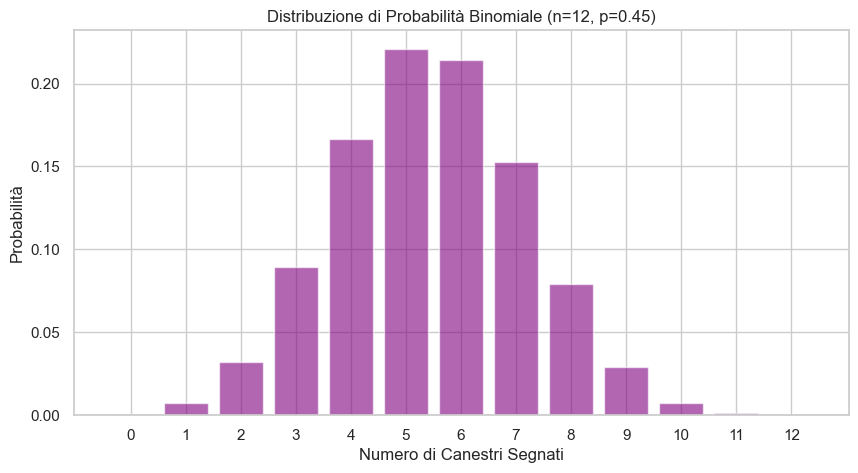

In [4]:
# 1. Calcolo Probabilità Frequentista (Dati Reali)
# Calcoliamo la % reale da 3 punti per la stagione
tiri_da_3 = player_data[player_data['SHOT_TYPE'] == '3PT Field Goal']
p_successo = tiri_da_3['SHOT_MADE_NUM'].mean()

print(f"Probabilità Frequentista (3PT% Reale): {p_successo:.2%}")

# 2. Scenario Probabilistico
# "Se il giocatore tenta 12 triple nella prossima partita, qual è la probabilità che ne segni ESATTAMENTE 7?"
n_prove = 12
k_successi = 7

# Calcolo usando scipy.stats.binom
prob_teorica = binom.pmf(k_successi, n_prove, p_successo)

print(f"\n--- Applicazione Modello Binomiale ---")
print(f"Scenario: {n_prove} tentativi con p={p_successo:.2f}")
print(f"Probabilità di segnarne esattamente {k_successi}: {prob_teorica:.2%} (Calcolata con combinazioni)")

# 3. Visualizzazione della distribuzione binomiale completa per n=12
x_axis = np.arange(0, n_prove + 1)
y_axis = binom.pmf(x_axis, n_prove, p_successo)

plt.figure(figsize=(10, 5))
plt.bar(x_axis, y_axis, color='purple', alpha=0.6)
plt.title(f'Distribuzione di Probabilità Binomiale (n={n_prove}, p={p_successo:.2f})')
plt.xlabel('Numero di Canestri Segnati')
plt.ylabel('Probabilità')
plt.xticks(x_axis)
plt.show()

## 5. Modellazione Statistica: Regressione Logistica
Analizziamo la relazione tra la variabile esplicativa **Distanza ($X$)** e la variabile risposta **Esito del Tiro ($Y$, Binaria)**.

1.  **Covarianza:** Calcoliamo prima la covarianza per vedere se esiste una dipendenza lineare inversa.
2.  **Regressione Logistica:** Costruiamo un modello predittivo. A differenza della regressione lineare, la logistica è adatta per variabili binarie (0/1) e utilizza la funzione sigmoide per stimare la probabilità tra 0 e 1.

Covarianza (Distanza, Esito): -0.0899
-> Interpretazione: Covarianza negativa. All'aumentare della distanza, l'esito tende ad essere negativo (Sbagliato).

--- Risultati Modello di Regressione Logistica ---
Accuratezza del modello (Accuracy): 53.65%
Coefficiente della Distanza (Beta): -0.3059
Intercetta: 0.7262


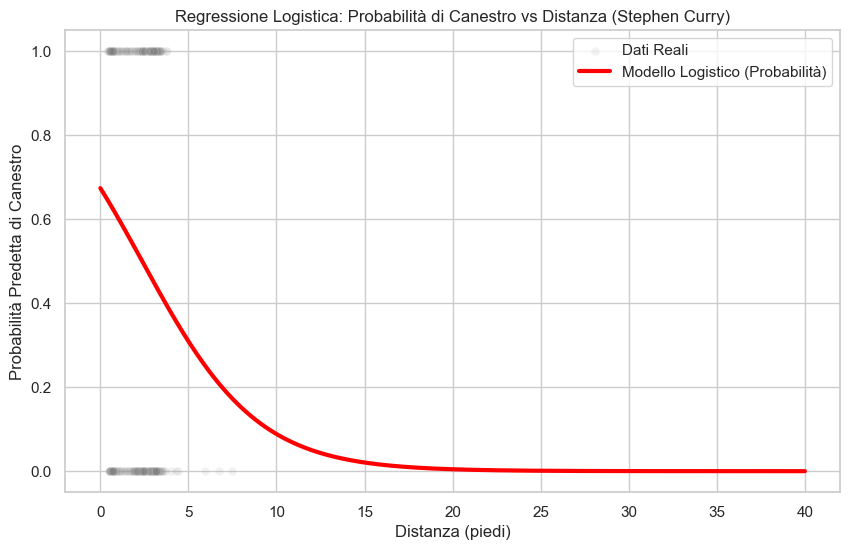

In [5]:
# 1. Analisi Covarianza
cov_matrix = np.cov(player_data['DISTANCE'], player_data['SHOT_MADE_NUM'])
covarianza = cov_matrix[0, 1]
print(f"Covarianza (Distanza, Esito): {covarianza:.4f}")
if covarianza < 0:
    print("-> Interpretazione: Covarianza negativa. All'aumentare della distanza, l'esito tende ad essere negativo (Sbagliato).")

# 2. Regressione Logistica con Scikit-Learn
X = player_data[['DISTANCE']] # Variabile Indipendente
y = player_data['SHOT_MADE_NUM'] # Variabile Dipendente (Target)

# Split Training/Test (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Addestramento Modello
model = LogisticRegression()
model.fit(X_train, y_train)

# Valutazione
accuracy = model.score(X_test, y_test)
coeficiente = model.coef_[0][0]
intercetta = model.intercept_[0]

print(f"\n--- Risultati Modello di Regressione Logistica ---")
print(f"Accuratezza del modello (Accuracy): {accuracy:.2%}")
print(f"Coefficiente della Distanza (Beta): {coeficiente:.4f}")
print(f"Intercetta: {intercetta:.4f}")

# VISUALIZZAZIONE CURVA SIGMOIDE (IL MODELLO)
plt.figure(figsize=(10, 6))

# Plot dei dati reali (scatter con jitter per vederli meglio)
sns.scatterplot(x=X_test['DISTANCE'], y=y_test, alpha=0.1, color='gray', label='Dati Reali')

# Plot della curva predittiva
x_range = np.linspace(0, 40, 300).reshape(-1, 1)
y_prob = model.predict_proba(x_range)[:, 1] # Probabilità di classe 1 (Segnato)

plt.plot(x_range, y_prob, color='red', linewidth=3, label='Modello Logistico (Probabilità)')
plt.title(f"Regressione Logistica: Probabilità di Canestro vs Distanza ({PLAYER_TARGET})")
plt.xlabel("Distanza (piedi)")
plt.ylabel("Probabilità Predetta di Canestro")
plt.legend()
plt.show()

## 6. Dashboard Interattiva
Utilizziamo i widget di Python (`ipywidgets`) per rendere l'analisi dinamica. Seleziona un giocatore dal menu per aggiornare istantaneamente statistiche e grafici.

--- ANALISI RAPIDA: Kobe Bryant ---
Tiri Totali: 17870
Distanza Media: 1.85 ft
FG%: 44.30%


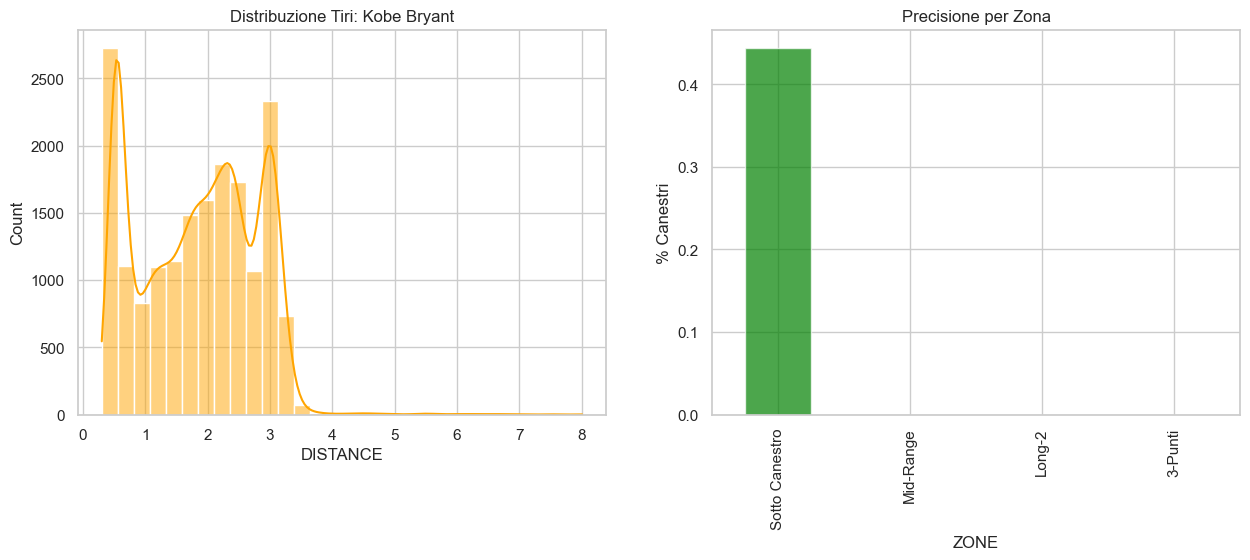

In [8]:
player_to_analyze = 'Kobe Bryant'  # <--- Cambia il nome qui se vuoi vederne un altro

# Filtro dati
subset = df[df['PLAYER_NAME'] == player_to_analyze]

if len(subset) > 0:
    dist = subset['DISTANCE']
    
    print(f"--- ANALISI RAPIDA: {player_to_analyze} ---")
    print(f"Tiri Totali: {len(dist)}")
    print(f"Distanza Media: {np.mean(dist):.2f} ft")
    print(f"FG%: {subset['SHOT_MADE_NUM'].mean():.2%}")

    # Grafici affiancati
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Grafico 1: Istogramma
    sns.histplot(dist, bins=30, kde=True, color='orange', ax=ax[0])
    ax[0].set_title(f"Distribuzione Tiri: {player_to_analyze}")

    # Grafico 2: Precisione per Zona
    # Ricalcoliamo le zone al volo per sicurezza
    zones = [0, 5, 15, 23, 40]
    subset_zone = subset.copy()
    subset_zone['ZONE'] = pd.cut(subset_zone['DISTANCE'], bins=zones, labels=['Sotto Canestro', 'Mid-Range', 'Long-2', '3-Punti'])
    
    acc = subset_zone.groupby('ZONE')['SHOT_MADE_NUM'].mean()
    acc.plot(kind='bar', color=['green', 'blue', 'purple', 'red'], ax=ax[1], alpha=0.7)
    ax[1].set_title("Precisione per Zona")
    ax[1].set_ylabel("% Canestri")
    plt.show()
else:
    print("Giocatore non trovato o dati insufficienti.")